In [ ]:
# NOTE:
# Model training and embedding generation were performed in a GPU-enabled environment
# as part of the Intel Unnati Program. Outputs are retained for demonstration purposes.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

import faiss

In [2]:
DATASET_DIR = "<DATASET_DIRECTORY>"

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

dataset = ImageFolder(root=DATASET_DIR, transform=transform)

loader = DataLoader(dataset, batch_size=32, shuffle=False)

image_paths = [s[0] for s in dataset.samples]
labels = [dataset.classes[s[1]] for s in dataset.samples]

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

weights = models.ResNet50_Weights.DEFAULT
resnet = models.resnet50(weights=weights)
model = nn.Sequential(*list(resnet.children())[:-1]).to(device).eval()

def extract_features(loader):
    feats = []
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device)
            out = model(images)
            out = out.view(out.size(0), -1)
            feats.append(out.cpu().numpy())
    return np.vstack(feats)

features = extract_features(loader)
print("Feature shape:", features.shape)

Feature shape: (9144, 2048)


In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=256, whiten=True)
features = pca.fit_transform(features)

# normalize again
features = features / np.linalg.norm(features, axis=1, keepdims=True)


In [5]:
import numpy as np
import faiss
from collections import defaultdict

# Normalize embeddings
features = features / np.linalg.norm(features, axis=1, keepdims=True)

# FAISS index for cosine similarity (inner product)
index = faiss.IndexFlatIP(features.shape[1])
index.add(features.astype(np.float32))

K = 5
label_arr = np.array(labels)

# Build label → indices map
label_to_indices = defaultdict(list)
for i, lb in enumerate(label_arr):
    label_to_indices[lb].append(i)

top1, topk = 0, 0
precision, recall = [], []

for i in range(len(features)):
    query_label = label_arr[i]

    # FAISS search
    D, I = index.search(features[i:i+1].astype(np.float32), K + 1)

    # Remove self-match
    retrieved = I[0][I[0] != i][:K]
    retrieved_labels = label_arr[retrieved]

    # Top-1 accuracy
    if retrieved_labels[0] == query_label:
        top1 += 1

    # Top-K accuracy
    if query_label in retrieved_labels:
        topk += 1

    # Precision@K
    rel = np.sum(retrieved_labels == query_label)
    precision.append(rel / K)

    # ✅ Retrieval-correct Recall@K
    total_rel = len(label_to_indices[query_label]) - 1
    recall.append(rel / min(K, total_rel) if total_rel > 0 else 0)

# Final metrics
top1_acc = top1 / len(features)
topk_acc = topk / len(features)
mean_prec = np.mean(precision)
mean_rec = np.mean(recall)

print("Top-1 Accuracy   :", top1_acc)
print("Top-K Accuracy   :", topk_acc)
print("Precision@K      :", mean_prec)
print("Recall@K         :", mean_rec)


Top-1 Accuracy   : 0.863517060367454
Top-K Accuracy   : 0.9669728783902012
Precision@K      : 0.8577646544181977
Recall@K         : 0.8577646544181977


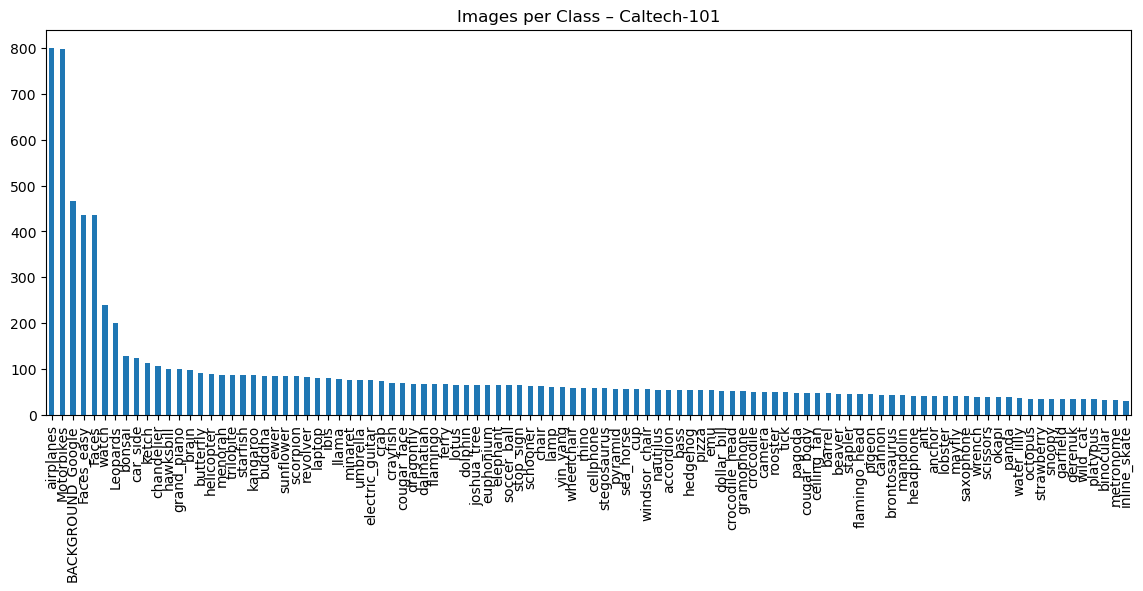

In [6]:
plt.figure(figsize=(14,5))
pd.Series(labels).value_counts().plot(kind='bar')
plt.title("Images per Class – Caltech-101")
plt.show()

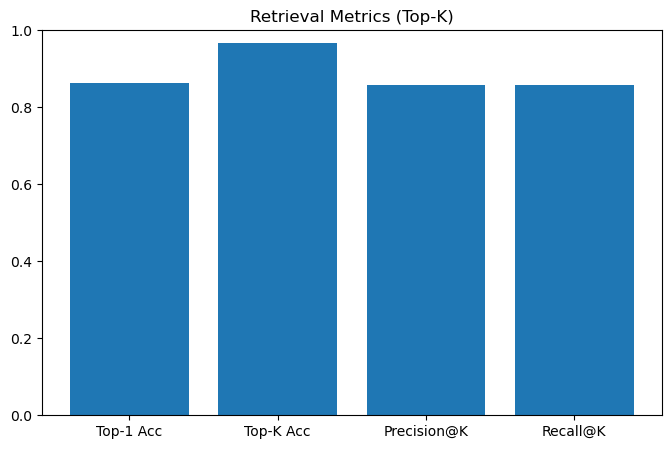

In [7]:
metrics = {
    "Top-1 Acc": top1_acc,
    "Top-K Acc": topk_acc,
    "Precision@K": mean_prec,
    "Recall@K": mean_rec
}

plt.figure(figsize=(8,5))
plt.bar(metrics.keys(), metrics.values())
plt.ylim(0,1)
plt.title("Retrieval Metrics (Top-K)")
plt.show()

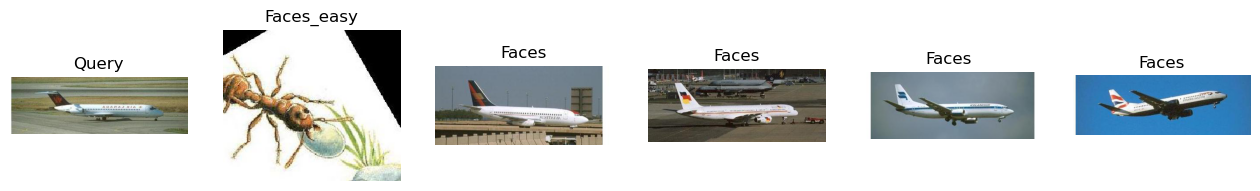

In [61]:
def visualize(query_idx, K=5):
    D, I = index.search(features[query_idx:query_idx+1].astype(np.float32), K+1)
    retrieved = I[0][1:]

    plt.figure(figsize=(16,4))
    plt.subplot(1, K+1, 1)
    plt.imshow(Image.open(image_paths[query_idx]))
    plt.title("Query")
    plt.axis('off')

    for k, idx in enumerate(retrieved, 2):
        plt.subplot(1, K+1, k)
        plt.imshow(Image.open(image_paths[idx]))
        plt.title(labels[idx])
        plt.axis('off')
    plt.show()

visualize(query_idx=467, K=5)

In [9]:
!pip install ipywidgets --upgrade

In [10]:
import ipywidgets as widgets
from IPython.display import display

display(widgets.Button(description="Test Button"))

Button(description='Test Button', style=ButtonStyle())

In [11]:
import random
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image
import io

In [12]:
# Upload option
upload_widget = widgets.FileUpload(
    accept="image/*",
    multiple=False,
    description="Upload Image"
)

# Path option
path_text = widgets.Text(
    placeholder="Enter full image path (e.g. dataset/images/img.jpg)",
    description="Image Path:"
)

# Dataset random option
random_button = widgets.Button(
    description="Use Random Dataset Image",
    button_style="info"
)

# K value
k_slider = widgets.IntSlider(
    value=5,
    min=1,
    max=10,
    step=1,
    description="Top-K:"
)

# Recommend button
recommend_button = widgets.Button(
    description="Recommend Images",
    button_style="success"
)

output = widgets.Output()

In [13]:
import io
from PIL import Image

def get_query_image():
    if upload_widget.value:
        file_info = upload_widget.value[0]   # tuple → first file
        image_bytes = file_info["content"]
        return Image.open(io.BytesIO(image_bytes)).convert("RGB")
    return None


In [14]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model.fc = torch.nn.Identity()
model = model.to(DEVICE)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

@torch.no_grad()
def extract_features(image):
    image = transform(image).unsqueeze(0).to(DEVICE)
    features = model(image)
    features = features.cpu().numpy()
    features = features / np.linalg.norm(features)
    return features


In [15]:
import os
import numpy as np
import pickle
from PIL import Image
from tqdm import tqdm
import time

image_dir = r"C:\Users\debar\OneDrive\Documents\Projects\Image Recommendation System\caltech-101\101_ObjectCategories"

embeddings = []
image_paths = []

start_time = time.perf_counter()
processed = 0
skipped = 0

for root, _, files in os.walk(image_dir):
    for file in files:
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            path = os.path.join(root, file)
            try:
                img = Image.open(path).convert("RGB")
                emb = extract_features(img)
                embeddings.append(emb[0])
                image_paths.append(path)
                processed += 1
            except Exception:
                skipped += 1
                print("Skipping:", path)

end_time = time.perf_counter()

embeddings = np.array(embeddings)

np.save("embeddings.npy", embeddings)
with open("image_paths.pkl", "wb") as f:
    pickle.dump(image_paths, f)

total_time = end_time - start_time
avg_time = total_time / processed if processed > 0 else 0

print("Embeddings created successfully!")
print(f"Total images processed : {processed}")
print(f"Images skipped         : {skipped}")
print(f"Total time taken       : {total_time:.2f} seconds")
print(f"Avg time per image     : {avg_time:.4f} seconds")
print("Embedding shape        :", embeddings.shape)


Embeddings created successfully!
Total images processed : 9144
Images skipped         : 0
Total time taken       : 182.84 seconds
Avg time per image     : 0.0200 seconds
Embedding shape        : (9144, 2048)


In [37]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import sys

def recommend_images(button):
    with output:
        clear_output()

        query_image = get_query_image()
        if query_image is None:
            print("Please upload an image.")
            return

        display(query_image)

        # Feature extraction
        query_embedding = extract_features(query_image)

        # Similarity
        similarities = cosine_similarity(query_embedding, embeddings)[0]
        k = k_slider.value
        top_k_idx = np.argsort(similarities)[::-1][:k]

        print(f"\nTop {k} Recommended Images:\n")

        for idx in top_k_idx:
            img = Image.open(image_paths[idx]).convert("RGB")
            display(img)
            print(f"Similarity Score: {similarities[idx]:.4f}\n")
        print("Recommendation completed. Exiting execution.")

recommend_button.on_click(recommend_images)

In [43]:
display(widgets.VBox([
    widgets.HTML("<h3>Query Image Selection</h3>"),
    upload_widget,
    path_text,
    random_button,
    k_slider,
    recommend_button,
    output
]))

DEBARATI_GHOSH